In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional, Input, Dot, Activation, Concatenate, Permute, Flatten, RepeatVector, Lambda
from sklearn.metrics import mean_absolute_error

In [3]:
# Sample data loading (replace this with your actual data loading code)
df = pd.read_csv(r'D:\binanceapi\MarketData\IOSTUSDT\IOSTUSDT_1m.csv')

# Convert timestamps if necessary
df['Open Time'] = pd.to_datetime(df['Open Time'])
df['Close Time'] = pd.to_datetime(df['Close Time'])

# Drop or convert the timestamp columns since LSTM cannot process datetime directly
df = df.drop(['Open Time', 'Close Time'], axis=1)

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Define the number of timesteps to look back
n_steps = 240  # This can be adjusted based on your use case

# Prepare the dataset for LSTM
def create_dataset(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps, 4])  # Assuming 'Close' is the target
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, n_steps)

# Reshape X for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the model on training data
def build_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(200, return_sequences=True), input_shape=(n_steps, X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')
    return model

model = build_model((X.shape[1], X.shape[2]))

# Train the model
history = model.fit(X_train, y_train, epochs=11, batch_size=32, validation_split=0.2)


Epoch 1/11
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 1766s 484ms/step - loss: 0.0347 - val_loss: 0.0462
Epoch 2/11
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 1714s 471ms/step - loss: 0.0195 - val_loss: 0.1296
Epoch 3/11
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 1697s 467ms/step - loss: 0.0169 - val_loss: 0.0471
Epoch 4/11
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 1655s 455ms/step - loss: 0.0148 - val_loss: 0.1211
Epoch 5/11
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 1650s 454ms/step - loss: 0.0131 - val_loss: 0.1078
Epoch 6/11
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 1659s 456ms/step - loss: 0.0122 - val_loss: 0.1125
Epoch 7/11
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 1665s 458ms/step - loss: 0.0113 - val_loss: 0.1999
Epoch 8/11
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 1666s 458ms/step - loss: 0.0228 - val_loss: 0.3036
Epoch 9/11
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 1690s 465ms/step - loss: 0.0163 - val_loss: 0.2228
Epoch 10/11
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 1667s 459ms/step - loss: 0.0143 - val_loss: 0.2334
Epoch 11/11
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 1674s 461ms/step - loss: 0

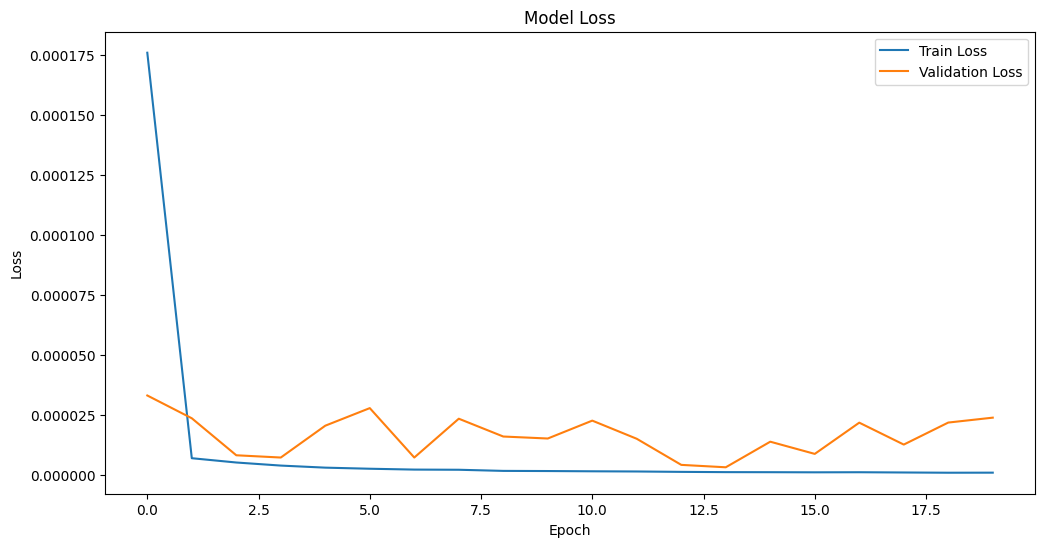

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


#It seems 10 epochs are enough 

1136/1136 ━━━━━━━━━━━━━━━━━━━━ 122s 108ms/step


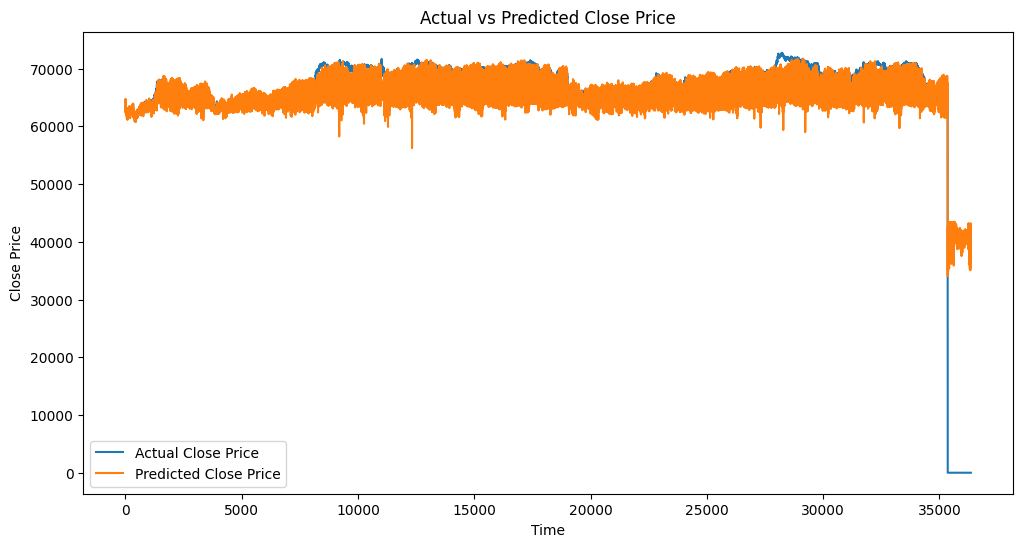

In [7]:
# Make predictions on the test set
y_pred = model.predict(X_test)
# Inverse transform the predictions and actual values to original scale manually
"""
y_test_inv = y_test * (scaler.data_max_[3] - scaler.data_min_[3]) + scaler.data_min_[3]
y_pred_inv = y_pred * (scaler.data_max_[3] - scaler.data_min_[3]) + scaler.data_min_[3]
"""

y_test_inv = y_test * scaler.scale_[3] + scaler.mean_[3]
y_pred_inv = y_pred * scaler.scale_[3] + scaler.mean_[3]

# Plot actual vs predicted close prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Close Price')
plt.plot(y_pred_inv, label='Predicted Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [4]:
def naive_forecast(data):
    return data[:-1]  # Predictions are the same as the last observed values

naive_scaler = StandardScaler()
y_naive_pred = naive_forecast(y_test)
# Fit the scaler on the actual test data
naive_scaler.fit(y_test.reshape(-1, 1))

# Scale naive forecast predictions and actual test data using the new scaler
y_naive_pred_scaled = naive_scaler.transform(y_naive_pred.reshape(-1, 1)).flatten()
y_test_scaled = naive_scaler.transform(y_test.reshape(-1, 1)).flatten()

# Compute naive forecast MAE on scaled values
naive_mae_scaled = mean_absolute_error(y_test_scaled[1:], y_naive_pred_scaled)

# Inverse transform the MAE to the original scale for minmax
#naive_mae = naive_mae_scaled * (naive_scaler.data_max_[0] - naive_scaler.data_min_[0])

naive_mae = naive_mae_scaled * naive_scaler.scale_[0]

print("Naive Forecast MAE (Original Scale):", naive_mae)

Naive Forecast MAE (Original Scale): 0.003176419491726917


standardScaling = Naive Forecast MAE (Original Scale): 0.003176419491726917


In [8]:
model.save(r'D:\binanceapi\MarketData\Saved_Models\2nd-bLstm\bLstm.h5')

print("Model saved to 'lstm_model.h5'")

Model saved to 'lstm_model.h5'


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Concatenate, Dot, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Load your dataset
df = pd.read_csv(r'D:\binanceapi\MarketData\IOSTUSDT\IOSTUSDT_1m.csv')

# Convert timestamps if necessary
df['Open Time'] = pd.to_datetime(df['Open Time'])
df['Close Time'] = pd.to_datetime(df['Close Time'])

# Drop or convert the timestamp columns since LSTM cannot process datetime directly
df = df.drop(['Open Time', 'Close Time'], axis=1)

# Compute log returns
df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Drop the first row with NaN return value
df = df.dropna()

# Feature scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Prepare the data for LSTM
def create_dataset(data, n_steps=60):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps, -1])  # Assuming 'Returns' is the last column
    return np.array(X), np.array(y)

n_steps = 60
X, y = create_dataset(scaled_data, n_steps)

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define the attention mechanism
def attention_block(inputs):
    attention_probs = Dense(units=n_steps, activation='softmax', name='attention_probs')(inputs)
    attention_mul = Dot(axes=1, name='attention_mul')([inputs, attention_probs])
    return attention_mul

# Define the model with attention mechanism
inputs = Input(shape=(n_steps, X_train.shape[2]))
lstm_out = Bidirectional(LSTM(50, return_sequences=True))(inputs)
attention_mul = attention_block(lstm_out)
output = Dense(1)(attention_mul)
model = Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 58s 15ms/step - loss: 4.0012e-04 - val_loss: 0.0011
Epoch 2/100
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - loss: 3.5706e-04 - val_loss: 9.5031e-04
Epoch 3/100
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - loss: 3.5876e-04 - val_loss: 9.5679e-04
Epoch 4/100
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - loss: 3.7545e-04 - val_loss: 9.5101e-04
Epoch 5/100
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 57s 16ms/step - loss: 3.7041e-04 - val_loss: 9.5004e-04
Epoch 6/100
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - loss: 3.7050e-04 - val_loss: 9.4961e-04
Epoch 7/100
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - loss: 3.5394e-04 - val_loss: 0.0010
Epoch 8/100
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - loss: 3.6290e-04 - val_loss: 0.0011
Epoch 9/100
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - loss: 3.7323e-04 - val_loss: 0.0011
Epoch 10/100
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 58s 16ms/step - loss: 3.7243e-04 - val_loss: 0.0015
Epoch 11/100
3639/3639 ━━━━━━

Model saved to 'attention_lstm_model_returns.h5'
Model loaded from 'attention_lstm_model_returns.h5'
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step


In [87]:
# Load your dataset
df = pd.read_csv(r'D:\binanceapi\MarketData\BTCUSDT\BTCUSDT_1m.csv')

# Convert timestamps if necessary
df['Open Time'] = pd.to_datetime(df['Open Time'])
df['Close Time'] = pd.to_datetime(df['Close Time'])

# Drop or convert the timestamp columns since LSTM cannot process datetime directly
df = df.drop(['Open Time', 'Close Time'], axis=1)

# Compute log returns
df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Drop the first row with NaN return value
df = df.dropna()

# Feature scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Prepare the data for LSTM
def create_dataset(data, n_steps=60):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps, -1])  # Assuming 'Returns' is the last column
    return np.array(X), np.array(y)

n_steps = 60
X, y = create_dataset(scaled_data, n_steps)

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define the attention mechanism
def attention_block(inputs):
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(n_steps, activation='softmax')(a)
    a = Permute((2, 1))(a)
    output_attention_mul = Dot(axes=1)([inputs, a])
    return output_attention_mul

# Define the model with attention mechanism
inputs = Input(shape=(n_steps, X_train.shape[2]))
lstm_out1 = Bidirectional(LSTM(100, return_sequences=True))(inputs)
dropout1 = Dropout(0.2)(lstm_out1)
lstm_out2 = Bidirectional(LSTM(50, return_sequences=True))(dropout1)
dropout2 = Dropout(0.2)(lstm_out2)
attention_mul = attention_block(dropout2)
attention_flatten = Flatten()(attention_mul)
output = Dense(1)(attention_flatten)
model = Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Save the model
model.save('attention_lstm_model_returns.h5')
print("Model saved to 'attention_lstm_model_returns.h5'")

Epoch 1/10
3656/3656 ━━━━━━━━━━━━━━━━━━━━ 122s 32ms/step - loss: 0.8047 - val_loss: 2.0049
Epoch 2/10
3656/3656 ━━━━━━━━━━━━━━━━━━━━ 116s 32ms/step - loss: 0.8127 - val_loss: 1.8184
Epoch 3/10
3656/3656 ━━━━━━━━━━━━━━━━━━━━ 117s 32ms/step - loss: 0.7859 - val_loss: 1.8163
Epoch 4/10
3656/3656 ━━━━━━━━━━━━━━━━━━━━ 114s 31ms/step - loss: 0.7689 - val_loss: 1.8163
Epoch 5/10
3656/3656 ━━━━━━━━━━━━━━━━━━━━ 114s 31ms/step - loss: 0.7712 - val_loss: 1.8162
Epoch 6/10
3656/3656 ━━━━━━━━━━━━━━━━━━━━ 115s 32ms/step - loss: 0.7581 - val_loss: 1.8166
Epoch 7/10
3656/3656 ━━━━━━━━━━━━━━━━━━━━ 116s 32ms/step - loss: 0.7539 - val_loss: 1.8163


Model saved to 'attention_lstm_model_returns.h5'


Model loaded from 'attention_lstm_model_returns.h5'
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step


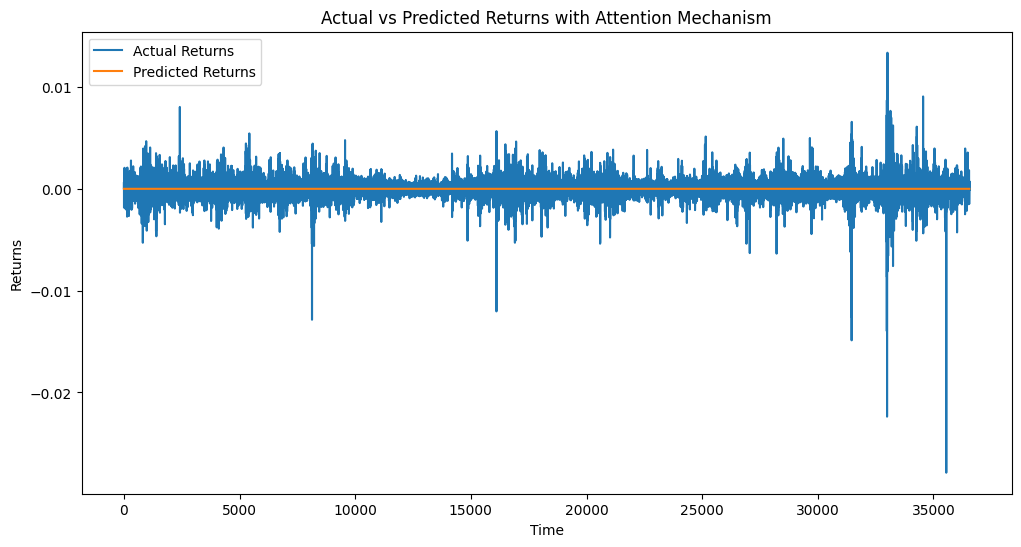

Mean Absolute Error (MAE): 0.0005502469180960923


In [88]:
loaded_model = load_model('attention_lstm_model_returns.h5')
print("Model loaded from 'attention_lstm_model_returns.h5'")
loaded_model.compile()
# Make predictions
y_pred = loaded_model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
y_test_inv = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test), df.shape[1] - 1)), y_test.reshape(-1, 1)], axis=1)
)[:, -1]
y_pred_inv = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred), df.shape[1] - 1)), y_pred], axis=1)
)[:, -1]

# Ensure both arrays have the same shape
assert y_test_inv.shape == y_pred_inv.shape, "Shapes of y_test_inv and y_pred_inv don't match"

# Plot actual vs predicted returns
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Returns')
plt.plot(y_pred_inv, label='Predicted Returns')
plt.title('Actual vs Predicted Returns with Attention Mechanism')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Compute and print mean absolute error (MAE)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print("Mean Absolute Error (MAE):", mae)

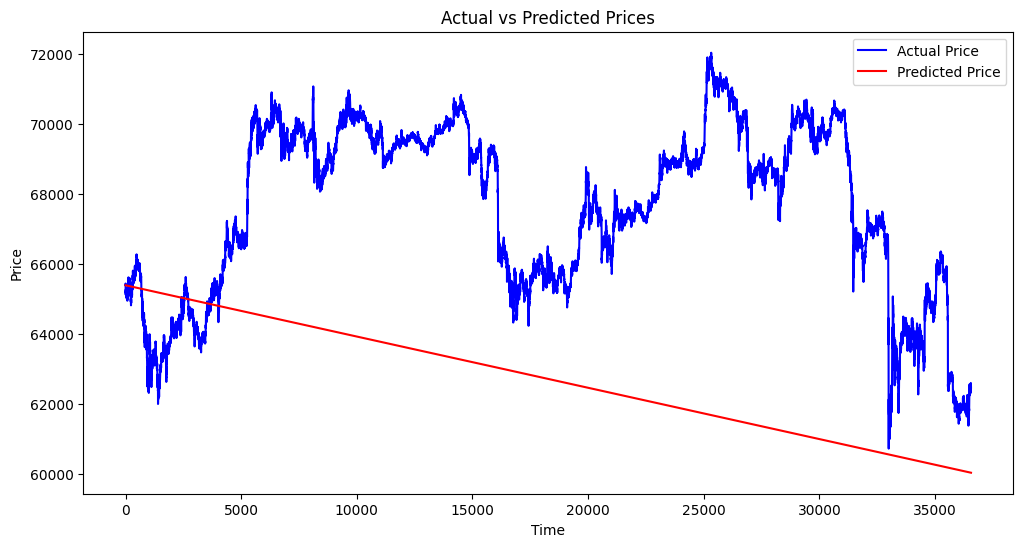

In [89]:
# Define the initial price (e.g., the closing price before the start of the prediction period)
initial_price = df.iloc[split - 1]['Close']

# Calculate the cumulative sum of actual and predicted returns
actual_cumulative_returns = np.cumsum(y_test_inv)
predicted_cumulative_returns = np.cumsum(y_pred_inv)

# Add 1 to the cumulative return series to get the multiplier for price growth
actual_price_multiplier = 1 + actual_cumulative_returns
predicted_price_multiplier = 1 + predicted_cumulative_returns

# Multiply the multiplier series by the initial price to get the predicted price series
actual_prices = initial_price * actual_price_multiplier
predicted_prices = initial_price * predicted_price_multiplier

# Plot actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(predicted_prices, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()